<a href="https://colab.research.google.com/github/RomaricKanyamibwa/ForestCoverTypePrediction/blob/master/ForestCoverTypePrediction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.model_selection import KFold,cross_val_score   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Restrict minor warnings
import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [2]:
#Import Data
col_names=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type']

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
covtype=pd.read_csv(data_url,delimiter=",",header =None,names=col_names)

In [3]:
#Distribution des differents Cover Type
tab=covtype["Cover_Type"].value_counts(ascending=True)
print(tab)

4      2747
5      9493
6     17367
7     20510
3     35754
1    211840
2    283301
Name: Cover_Type, dtype: int64


on observe que les données ne sont pas du tout equilibré

# Construction des données equilibré

In [12]:
covtype_balanced=covtype[covtype['Cover_Type']==4].sample(frac=0.79)#(n=2160)
frames = [covtype_balanced]
random.seed(1)
for i in range(1,8):
    if i!=4:
        frames.append(covtype[covtype['Cover_Type']==i].sample(int(len(covtype_balanced)*(1+random.uniform(0.5,1.5)))))
                      
covtype_balanced=pd.concat(frames)
covtype_balanced=covtype_balanced.sample(frac=1)#.reset_index(drop=True)#melange des données
tab=covtype_balanced["Cover_Type"].value_counts(ascending=True)
print(tab)
print("Balanced Data Size:",len(covtype_balanced))

4    2170
1    3546
5    3808
7    4230
6    4330
3    4912
2    5093
Name: Cover_Type, dtype: int64
Balanced Data Size: 28089


In [13]:
covtype_balanced.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,...,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000
mean,2771.233116,157.473424,16.475061,236.722133,51.903663,1765.353412,211.372103,218.895333,136.652497,1567.884083,...,0.046922,0.042971,0.002065,0.008224,0.000356,0.002314,0.050020,0.045534,0.027733,3.979423
std,405.740841,111.250776,8.455419,209.457898,61.170648,1363.918077,31.017527,23.270665,45.285246,1136.076819,...,0.211476,0.202794,0.045395,0.090313,0.018865,0.048050,0.217989,0.208476,0.164211,2.035572
min,1860.000000,0.000000,0.000000,0.000000,-159.000000,0.000000,0.000000,85.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2430.000000,63.000000,10.000000,85.000000,7.000000,760.000000,194.000000,207.000000,109.000000,755.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2773.000000,126.000000,15.000000,190.000000,34.000000,1358.000000,219.000000,223.000000,139.000000,1307.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3113.000000,264.000000,22.000000,335.000000,81.000000,2372.000000,234.000000,236.000000,168.000000,2072.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3858.000000,360.000000,54.000000,1320.000000,478.000000,7020.000000,254.000000,254.000000,250.000000,7084.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


# Analyse de données 
verifiecation des proprietes vu dans le dataset globale

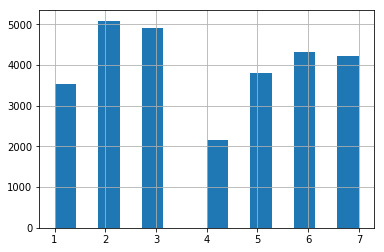

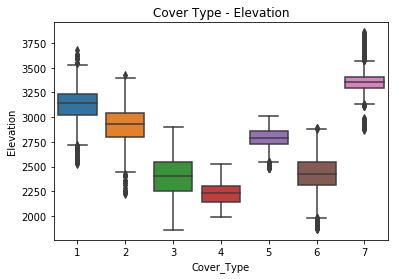

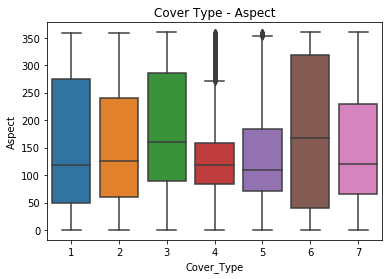

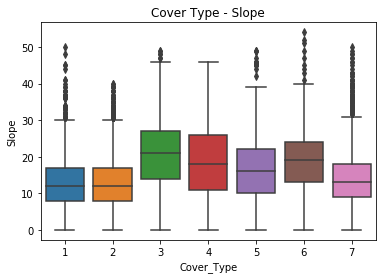

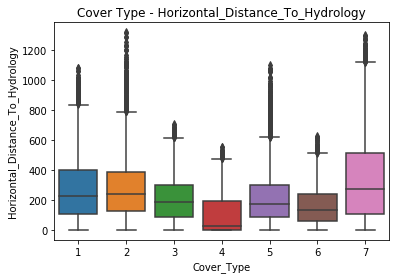

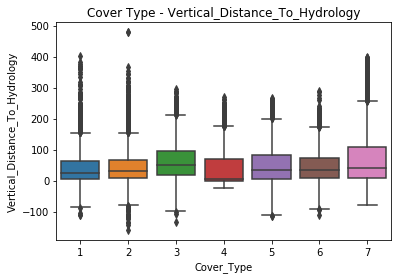

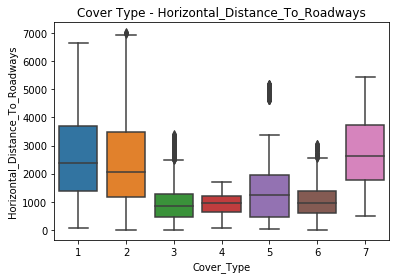

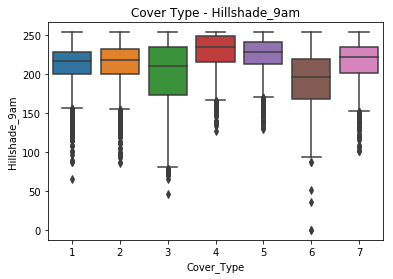

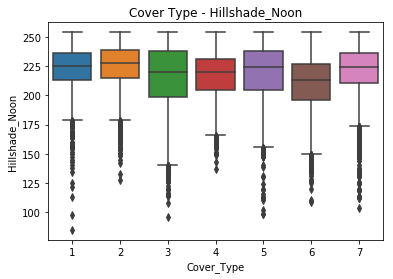

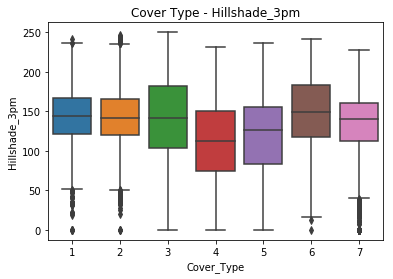

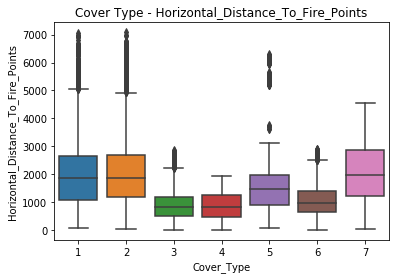

In [14]:
#Histograme 
covtype_balanced['Cover_Type'].hist(bins=2*7);
plt.show()
#sns.boxplot(x="Cover_Type",y="Elevation", data=covtype);
cols = covtype_balanced.columns
size = 10#len(cols) - 1 # on enleve cover_type
# l'axe de x  represente les 7 classes classes
x = cols[-1]
y = cols[0:size]

for i in range(0, size):
    ax=sns.boxplot(data=covtype_balanced, x=x, y=y[i])
    title="Cover Type - "+col_names[i]
    ax.set_title(title)
    #ax = sns.swarmplot(data=covtype, x=x, y=y[i])
    plt.show()

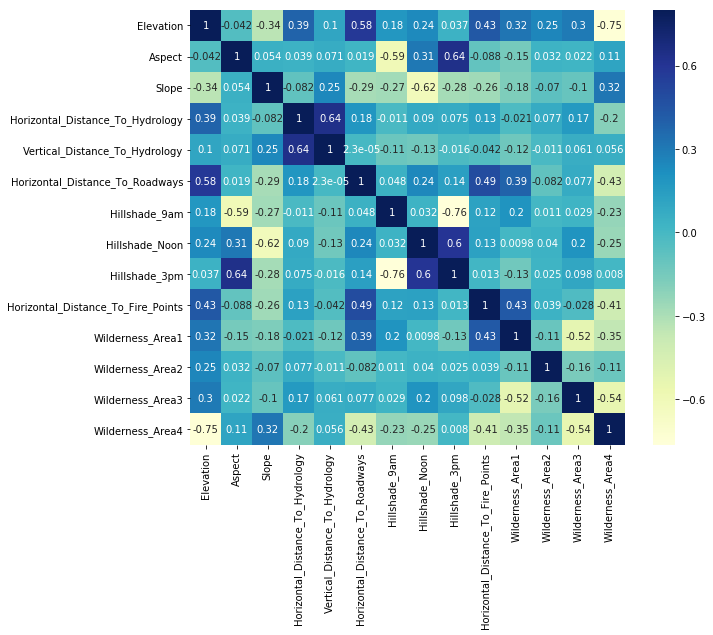

In [15]:
#Matrice de correlation ,on va  étudier l'intensité de la liaison qui peut exister entre les differents variables

size = 14
corrmat = covtype_balanced.iloc[:,:size].corr()
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,cmap="YlGnBu");

# Selection des Variables 
**Feature importances**

In [30]:
#Seletion des variables avec l'attribut feature_importances des arbres de classifications
def best_n_features(data,n=10,n_classes=7):
    X = data.iloc[:,:-1]  #independent columns
    y = data.iloc[:,-1]    #target column i.e price range

    model = ExtraTreesClassifier(n_classes)
    model.fit(X,y)
    #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    #print(list(feat_importances.nlargest(n).index))
    plt.show();
    return (feat_importances)

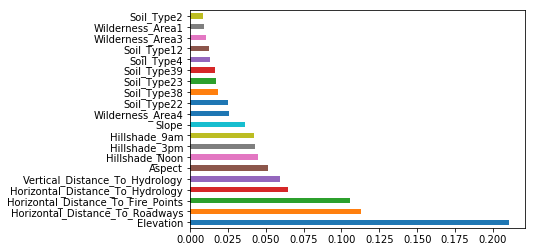

In [32]:
globl_features=best_n_features(covtype,n=20)

**Unvariate feature selection with  chi2**

In [40]:
X = covtype.drop(["Cover_Type","Vertical_Distance_To_Hydrology"],axis=1)  #remove label and negative values
y = covtype.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 15 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features

                                 Specs         Score
4      Horizontal_Distance_To_Roadways  5.766452e+07
8   Horizontal_Distance_To_Fire_Points  3.589090e+07
0                            Elevation  9.479853e+06
3     Horizontal_Distance_To_Hydrology  2.322605e+06
12                    Wilderness_Area4  2.949092e+05
1                               Aspect  2.146782e+05
2                                Slope  1.714326e+05
22                         Soil_Type10  1.219068e+05
16                          Soil_Type4  6.637906e+04
50                         Soil_Type38  6.569458e+04
7                        Hillshade_3pm  6.358794e+04
5                        Hillshade_9am  6.339071e+04
51                         Soil_Type39  6.212286e+04
15                          Soil_Type3  6.109861e+04
14                          Soil_Type2  5.495303e+04


**features selected list**

In [41]:
n_feat=20#number of features
feat=featureScores.nlargest(n_feat,'Score')
list_feat=list(feat['Specs'])
predictors=[list_feat,list(globl_features.nlargest(n_feat).index)] #Our list of features
type_pred=[" Chi2Sel"," FeatImpo"]

# **Construction des Modeles Predictifs**

**Fonction de Train et test **

In [42]:
#fonction generique pour un classifieur et sa performance:
def classification_model(model, train_data,test_data, predictors, outcome,cross_valid=True):
    #entrainement du model:
    tp_d=time()
    model.fit(train_data[predictors],train_data[outcome])
    tr_time = time()-tp_d

    #predictions sur le test set:
    predictions = model.predict(test_data[predictors])

    #affichage de l'accuracy
    accuracy = metrics.accuracy_score(predictions,test_data[outcome])
    print ("\tAccuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 5 folds
    #kf = KFold(n_splits = 10, shuffle = True)#, random_state = 2
    if(cross_valid):
        error = cross_val_score(model,data[predictors],train_data[outcome], cv=5,n_jobs=4)
        print ("\tCross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
        #Fit the model again so that it can be refered outside the function:
        model.fit(train_data[predictors],data[outcome])
    else:
        error=[0]

    return accuracy,tr_time,len(predictors),np.mean(error)

**Scaling Train set**

In [43]:
outcome_var = 'Cover_Type'
end=10 #only categorical variables
scaler = StandardScaler()
#we scale to speed up convergence
scaled_covtype_balanced=covtype_balanced.copy()
scaled_covtype_balanced[col_names[:end]]=scaler.fit_transform(scaled_covtype_balanced[col_names[:end]])
#scaled_covtype_balanced.describe()

**Test Set**

In [46]:
testcovtype=covtype.drop(covtype_balanced.index)
outcome_var = 'Cover_Type'

#Normalisation
end=10 #only categorical variables
scaler = StandardScaler()
#we scale to speed up convergence
testcovtype[col_names[:end]]=scaler.fit_transform(testcovtype[col_names[:end]])
testcovtype.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,...,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000
mean,3.189803e-15,-2.338887e-15,-9.461773e-15,-4.193039e-16,5.334489e-14,-3.541355e-14,-3.408093e-15,1.722410e-14,1.045646e-14,-1.834762e-14,...,0.092601,0.079481,0.002809,0.003002,0.000197,0.000421,0.025624,0.022656,0.014416,1.953529
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,0.289872,0.270489,0.052923,0.054710,0.014039,0.020524,0.158010,0.148804,0.119199,1.280777
min,-4.132953e+00,-1.389633e+00,-1.885666e+00,-1.275291e+00,-3.769729e+00,-1.522914e+00,-7.996322e+00,-1.143598e+01,-3.772553e+00,-1.505108e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-5.359160e-01,-8.715281e-01,-6.719991e-01,-7.672249e-01,-6.733042e-01,-8.017251e-01,-5.345833e-01,-5.393779e-01,-6.029342e-01,-7.199292e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.194447e-01,-2.551622e-01,-1.325913e-01,-2.027075e-01,-2.948523e-01,-2.193991e-01,2.191277e-01,1.256726e-01,4.575950e-03,-2.024933e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.263982e-01,9.329052e-01,5.416684e-01,5.593911e-01,3.760398e-01,6.304129e-01,7.090399e-01,6.884077e-01,6.649131e-01,4.262514e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3.310605e+00,1.826189e+00,7.014561e+00,5.296633e+00,9.544898e+00,3.031388e+00,1.575808e+00,1.558089e+00,2.936473e+00,3.889612e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [44]:
TrainingTime=[]
Accuracy=[]
Nb_Features=[]
Classifier=[]
Cross_Validation=[]

In [48]:
names = ["Logit"#,"Lasso"
         ,"Nearest Neighbors", "Linear SVM", "RBF SVM",
         #"Gaussian Process",
         "Decision Tree", "Random Forest 7","Random Forest 100","Random Forest 500",
         "ExtraTreesClassifier 100","ExtraTreesClassifier 500",
         "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter = 450,n_jobs=4),
    #Lasso(alpha=0.1, copy_X=True),
    KNeighborsClassifier(7,n_jobs=4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0),n_jobs=4),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=15,n_jobs=4,bootstrap=True),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=15,n_jobs=4,bootstrap=True),
    RandomForestClassifier(max_depth=5, n_estimators=500, max_features=15,n_jobs=4,bootstrap=True),
    ExtraTreesClassifier(max_depth=5, n_estimators=100, max_features=15,n_jobs=4,bootstrap=True),
    ExtraTreesClassifier(max_depth=5, n_estimators=500, max_features=15,n_jobs=4,bootstrap=True),
    MLPClassifier(alpha= 0.0001,max_iter=450),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

**Training with Chi2 et FeatImpo selection**

In [50]:
#predictors=[list_feat] #Our list of features
#type_pred=[" Chi2Sel"]
for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index]," with ",n_feat," best feature(s)","--------")
    for k,pred in enumerate(predictors):
        print("\t---",type_pred[k])
        accuracy,tr_time,nb_features,cross_val=classification_model(
        clsf, train_data=scaled_covtype_balanced,test_data=testcovtype,
        predictors=pred,outcome=outcome_var,cross_valid=False)
  
        classifier_type=names[clsf_index]+type_pred[k]

        TrainingTime.append(tr_time)
        Accuracy.append(accuracy)
        Nb_Features.append(nb_features)
        Classifier.append(classifier_type)
        Cross_Validation.append(cross_val)

-------- Logit  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 38.009%
	---  FeatImpo
	Accuracy : 40.286%
-------- Nearest Neighbors  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 53.150%
	---  FeatImpo


KeyboardInterrupt: 

In [52]:
d = {'Type of Classifier':Classifier,'Number of Features':Nb_Features,
     'Training Time': TrainingTime, 'Accuracy': Accuracy,'Cross-Validation':Cross_Validation}

df = pd.DataFrame(data=d)
df = df[list(d.keys())]
df.sort_values(by=['Accuracy'],ascending=False).head(50)

,Type of Classifier,Number of Features,Training Time,Accuracy,Cross-Validation
2,Nearest Neighbors Chi2Sel,20,0.056396,0.531504,0.0
1,Logit FeatImpo,20,6.674563,0.402855,0.0
0,Logit Chi2Sel,20,26.781359,0.380091,0.0


In [80]:
latex=df.sort_values(by=['Accuracy'],ascending=False).head(50).to_latex()
df.to_csv("latex_features20_2.csv")
df.sort_values(by=['Accuracy'],ascending=False).head(50)

,Type of Classifier,Number of Features,Training Time,Accuracy,Cross-Validation
7,RBF SVM FeatImpo,20,54.503555,0.973347,0.802712
6,RBF SVM Chi2Sel,20,30.519669,0.957804,0.812103
17,Neural Net FeatImpo,20,36.862653,0.871429,0.810251
16,Neural Net Chi2Sel,20,42.897423,0.866336,0.813889
2,Nearest Neighbors Chi2Sel,20,0.146458,0.843981,0.770304
3,Nearest Neighbors FeatImpo,20,0.016246,0.841667,0.767791
0,Logit Chi2Sel,20,2.352511,0.694907,0.690013
1,Logit FeatImpo,20,2.440092,0.693254,0.690278
5,Linear SVM FeatImpo,20,3.788670,0.692791,0.688558
4,Linear SVM Chi2Sel,20,4.308234,0.689616,0.685119


In [18]:
d = {'Type of Classifier':Classifier,'Number of Features':Nb_Features,
     'Training Time': TrainingTime, 'Accuracy': Accuracy,'Cross-Validation':Cross_Validation}

df3 = pd.DataFrame(data=d)
df3 = df3[list(d.keys())]
df3.sort_values(by=['Accuracy'],ascending=False).head(50)

,Type of Classifier,Number of Features,Training Time,Accuracy,Cross-Validation
7,RBF SVM FeatImpo,15,82.531964,0.958677,0.812822
6,RBF SVM Chi2Sel,15,52.389378,0.927726,0.824991
2,Nearest Neighbors Chi2Sel,15,0.031588,0.848387,0.776643
3,Nearest Neighbors FeatImpo,15,0.024424,0.842344,0.766558
17,Neural Net FeatImpo,15,54.716731,0.841731,0.808087
16,Neural Net Chi2Sel,15,55.784248,0.836382,0.801103
5,Linear SVM FeatImpo,15,14.386122,0.672234,0.669089
1,Logit FeatImpo,15,4.930157,0.669988,0.666885
4,Linear SVM Chi2Sel,15,15.349996,0.667415,0.664966
0,Logit Chi2Sel,15,5.515417,0.665619,0.662761


# Model testing

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,5.565220e+05,5.565220e+05,5.565220e+05,5.565220e+05,5.565220e+05,5.565220e+05,5.565220e+05,5.565220e+05,5.565220e+05,5.565220e+05,...,556522.000000,556522.000000,556522.000000,556522.000000,556522.000000,556522.000000,556522.000000,556522.000000,556522.000000,556522.000000
mean,1.239385e-14,-9.392458e-15,-4.486601e-14,6.585429e-14,-6.843502e-14,-5.648756e-15,-1.105018e-14,-5.703428e-15,-1.936931e-15,-8.329018e-15,...,0.092214,0.079125,0.002814,0.002979,0.000187,0.000420,0.025334,0.022497,0.014260,1.968082
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,0.289328,0.269935,0.052972,0.054501,0.013669,0.020501,0.157138,0.148293,0.118561,1.290644
min,-4.088703e+00,-1.390016e+00,-1.885090e+00,-1.274879e+00,-3.769822e+00,-1.518308e+00,-7.974305e+00,-1.139867e+01,-3.761879e+00,-1.502286e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-5.385140e-01,-8.718293e-01,-6.742245e-01,-7.661893e-01,-6.739954e-01,-8.009686e-01,-5.325509e-01,-5.351672e-01,-5.998937e-01,-7.199601e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.227596e-01,-2.553656e-01,-1.360622e-01,-2.009785e-01,-2.956166e-01,-2.231295e-01,2.191415e-01,1.278632e-01,6.153507e-03,-2.031735e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.286192e-01,9.328905e-01,5.366407e-01,5.620560e-01,3.751457e-01,6.285912e-01,7.077415e-01,6.888889e-01,6.649005e-01,4.256963e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3.296134e+00,1.826316e+00,6.994589e+00,5.305116e+00,9.542232e+00,3.035934e+00,1.572188e+00,1.555929e+00,2.930990e+00,3.893507e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [20]:
def test_model(model,data,predictors,outcome):#,train_data
  
    #score=model.score(data[predictors],data[outcome])
    #print ("Accuracy : %s" % "{0:.3%}".format(score))
    #model.fit(train_data[predictors],train_data[outcome])
    #print("\tend of fitting")
    #predictions sur le training set:
    predictions = model.predict(data[predictors])

    #affichage de l'accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ("\tAccuracy : %s" % "{0:.3%}".format(accuracy))
  

In [61]:
for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[1],outcome_var)

-------- Logit  Testing  --------
Accuracy : 37.510%
-------- Nearest Neighbors  Testing  --------
Accuracy : 49.727%
-------- Linear SVM  Testing  --------
Accuracy : 36.521%
-------- RBF SVM  Testing  --------
Accuracy : 58.999%
-------- Decision Tree  Testing  --------
Accuracy : 34.955%
-------- Random Forest 7  Testing  --------
Accuracy : 35.987%
-------- Random Forest 100  Testing  --------
Accuracy : 43.231%
-------- Random Forest 500  Testing  --------
Accuracy : 42.454%
-------- Neural Net  Testing  --------
Accuracy : 53.259%
-------- AdaBoost  Testing  --------
Accuracy : 16.526%
-------- Naive Bayes  Testing  --------
Accuracy : 17.049%
-------- QDA  Testing  --------
Accuracy : 37.053%


In [24]:
for clsf_index,clsf in enumerate(classifiers):
    #for k,pred in enumerate(predictors):
    print("--------",names[clsf_index],type_pred[1]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[1],outcome_var)#,covtype_balanced

-------- Logit  FeatImpo  Testing  --------
	Accuracy : 41.307%
-------- Nearest Neighbors  FeatImpo  Testing  --------
	Accuracy : 54.139%
-------- Linear SVM  FeatImpo  Testing  --------
	Accuracy : 41.404%
-------- RBF SVM  FeatImpo  Testing  --------
	Accuracy : 58.453%
-------- Decision Tree  FeatImpo  Testing  --------
	Accuracy : 32.774%
-------- Random Forest 7  FeatImpo  Testing  --------
	Accuracy : 33.769%
-------- Random Forest 100  FeatImpo  Testing  --------
	Accuracy : 37.289%
-------- Random Forest 500  FeatImpo  Testing  --------
	Accuracy : 38.655%
-------- Neural Net  FeatImpo  Testing  --------
	Accuracy : 55.976%
-------- AdaBoost  FeatImpo  Testing  --------
	Accuracy : 40.603%
-------- Naive Bayes  FeatImpo  Testing  --------
	Accuracy : 11.619%
-------- QDA  FeatImpo  Testing  --------
	Accuracy : 0.133%


In [26]:
for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index],type_pred[0]," with ",n_feat," best feature(s)","--------")
    clsf.fit(scaled_covtype_balanced[predictors[0]],scaled_covtype_balanced[outcome_var])
    
    #predictions sur le training set:
    predictions = clsf.predict(scaled_covtype_balanced[predictors[0]])

    #affichage de l'accuracy
    accuracy = metrics.accuracy_score(predictions,scaled_covtype_balanced[outcome_var])
    print ("\tAccuracy : %s" % "{0:.3%}".format(accuracy))

-------- Logit  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 66.562%
-------- Nearest Neighbors  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 84.839%
-------- Linear SVM  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 66.742%
-------- RBF SVM  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 92.773%
-------- Decision Tree  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 63.977%
-------- Random Forest 7  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 59.506%
-------- Random Forest 100  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 63.491%
-------- Random Forest 500  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 63.140%
-------- Neural Net  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 83.932%
-------- AdaBoost  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 45.345%
-------- Naive Bayes  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 43.593%
-------- QDA  Chi2Sel  with  15  best feature

In [27]:
for clsf_index,clsf in enumerate(classifiers):
    #for k,pred in enumerate(predictors):
    print("--------",names[clsf_index],type_pred[0]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[0],outcome_var)#,covtype_balanced

-------- Logit  Chi2Sel  Testing  --------
	Accuracy : 40.498%
-------- Nearest Neighbors  Chi2Sel  Testing  --------
	Accuracy : 52.181%
-------- Linear SVM  Chi2Sel  Testing  --------
	Accuracy : 40.852%
-------- RBF SVM  Chi2Sel  Testing  --------
	Accuracy : 56.583%
-------- Decision Tree  Chi2Sel  Testing  --------
	Accuracy : 33.879%
-------- Random Forest 7  Chi2Sel  Testing  --------
	Accuracy : 37.504%
-------- Random Forest 100  Chi2Sel  Testing  --------
	Accuracy : 39.028%
-------- Random Forest 500  Chi2Sel  Testing  --------
	Accuracy : 37.288%
-------- Neural Net  Chi2Sel  Testing  --------
	Accuracy : 48.264%
-------- AdaBoost  Chi2Sel  Testing  --------
	Accuracy : 30.176%
-------- Naive Bayes  Chi2Sel  Testing  --------
	Accuracy : 7.757%
-------- QDA  Chi2Sel  Testing  --------
	Accuracy : 37.243%


In [33]:
for clsf_index,clsf in enumerate(classifiers):
    #for k,pred in enumerate(predictors):
    print("--------",names[clsf_index],type_pred[0]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[0],outcome_var)#,covtype_balanced

-------- Logit  Chi2Sel  Testing  --------
	Accuracy : 42.113%
-------- Nearest Neighbors  Chi2Sel  Testing  --------
	Accuracy : 56.954%
-------- Linear SVM  Chi2Sel  Testing  --------
	Accuracy : 42.879%
-------- RBF SVM  Chi2Sel  Testing  --------
	Accuracy : 59.829%
-------- Decision Tree  Chi2Sel  Testing  --------
	Accuracy : 41.632%
-------- Random Forest 7  Chi2Sel  Testing  --------
	Accuracy : 35.137%
-------- Random Forest 100  Chi2Sel  Testing  --------
	Accuracy : 37.004%
-------- Random Forest 500  Chi2Sel  Testing  --------
	Accuracy : 38.762%
-------- Neural Net  Chi2Sel  Testing  --------
	Accuracy : 58.438%
-------- AdaBoost  Chi2Sel  Testing  --------
	Accuracy : 30.175%
-------- Naive Bayes  Chi2Sel  Testing  --------
	Accuracy : 6.617%
-------- QDA  Chi2Sel  Testing  --------
	Accuracy : 37.243%


In [44]:
predictors=[list(globl_features.nlargest(n_feat).index)] #Our list of features
type_pred=[" FeatImpo"]
for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index]," with ",n_feat," best feature(s)","--------")
    for k,pred in enumerate(predictors):
        print("\t---",type_pred[k])
        accuracy,tr_time,nb_features,cross_val=classification_model(
        clsf, scaled_covtype_balanced,
        pred,outcome_var,cross_valid=False)
  
        classifier_type=names[clsf_index]+type_pred[k]

        TrainingTime.append(tr_time)
        Accuracy.append(accuracy)
        Nb_Features.append(nb_features)
        Classifier.append(classifier_type)
        Cross_Validation.append(cross_val)

-------- Logit  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 67.840%
-------- Nearest Neighbors  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 84.749%
-------- Linear SVM  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 68.158%
-------- RBF SVM  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 96.415%
-------- Decision Tree  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 65.272%
-------- Random Forest 7  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 55.337%
-------- Random Forest 100  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 61.258%
-------- Random Forest 500  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 63.483%
-------- Neural Net  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 86.129%
-------- AdaBoost  with  20  best feature(s) --------
	---  FeatImpo
	Accuracy : 43.655%
-------- Naive Bayes  with  20  best feature(s) --------
	---  FeatImpo

In [45]:
for clsf_index,clsf in enumerate(classifiers):
    #for k,pred in enumerate(predictors):
    print("--------",names[clsf_index],type_pred[0]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[0],outcome_var)#,covtype_balanced

-------- Logit  FeatImpo  Testing  --------
	Accuracy : 43.851%
-------- Nearest Neighbors  FeatImpo  Testing  --------
	Accuracy : 57.453%
-------- Linear SVM  FeatImpo  Testing  --------
	Accuracy : 43.477%
-------- RBF SVM  FeatImpo  Testing  --------
	Accuracy : 57.003%
-------- Decision Tree  FeatImpo  Testing  --------
	Accuracy : 41.362%
-------- Random Forest 7  FeatImpo  Testing  --------
	Accuracy : 38.690%
-------- Random Forest 100  FeatImpo  Testing  --------
	Accuracy : 43.363%
-------- Random Forest 500  FeatImpo  Testing  --------
	Accuracy : 42.200%
-------- Neural Net  FeatImpo  Testing  --------
	Accuracy : 56.194%
-------- AdaBoost  FeatImpo  Testing  --------
	Accuracy : 40.603%
-------- Naive Bayes  FeatImpo  Testing  --------
	Accuracy : 15.298%
-------- QDA  FeatImpo  Testing  --------
	Accuracy : 5.806%
